# Multi-lable classificatin


In [12]:
%matplotlib inline
import math
import os
import data_util
#from data_util import DataPoint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import MultiLabelBinarizer # convert y to {0,1}^L
from sklearn.preprocessing import StandardScaler # normalize features 
from sklearn.feature_extraction import DictVectorizer # extract feature vector to x
from numpy.random import normal # generate transforming matrix
from sklearn.neighbors import KDTree #KDTree for fast kNN search
from sklearn.externals import joblib # store classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import VarianceThreshold

In [2]:
!ls -R ../data

../data:
AmazonCat  Bibtex  Delicious  Eurlex  Mediamill  RCV1-x  Wiki10

../data/AmazonCat:
amazonCat_test.txt  amazonCat_train.txt

../data/Bibtex:
Bibtex_data.txt  bibtex_trSplit.txt  bibtex_tstSplit.txt

../data/Delicious:
Delicious_data.txt  delicious_trSplit.txt  delicious_tstSplit.txt

../data/Eurlex:
eurlex_test.txt  eurlex_train.txt

../data/Mediamill:
Mediamill_data.txt  mediamill_trSplit.txt  mediamill_tstSplit.txt

../data/RCV1-x:
rcv1x_test.txt	rcv1x_train.txt

../data/Wiki10:
wiki10_test.txt  wiki10_train.txt


In [3]:
#!head ../data/Eurlex/eurlex_train.txt

In [4]:
data_dir = "../data"
model_dir = "../.model2"
train_filename = "/Eurlex/eurlex_train.txt"
test_filename = "/Eurlex/eurlex_test.txt"

path = os.path.dirname(train_filename)
model_path = model_dir + path

In [5]:
tr_data, num_point, num_feature, num_label = data_util.read_file(data_dir+train_filename)
print("num_point={}, num_label={}, num_feature={}".format(num_point, num_label, num_feature))

num_point=15539, num_label=3993, num_feature=5000


In [6]:
te_data, _, _, _ = data_util.read_file(data_dir+test_filename)

In [7]:
X_tr, Y_tr, X_te, Y_te = data_util.data_transform(tr_data, te_data, num_label)

## Explore Data Analysis

/home/horacehxw/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


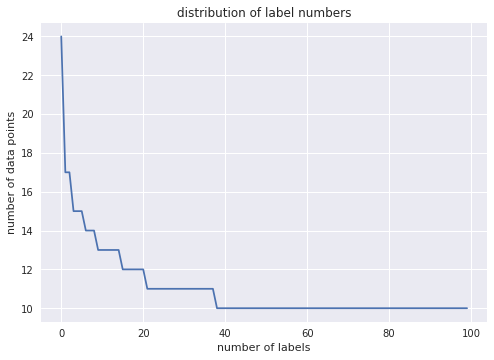

In [8]:
# number of labels for each data point
plt.plot(sorted([Y.sum() for Y in Y_tr], reverse=True)[:100])
plt.xlabel('number of labels')
plt.ylabel('number of data points')
plt.title('distribution of label numbers')

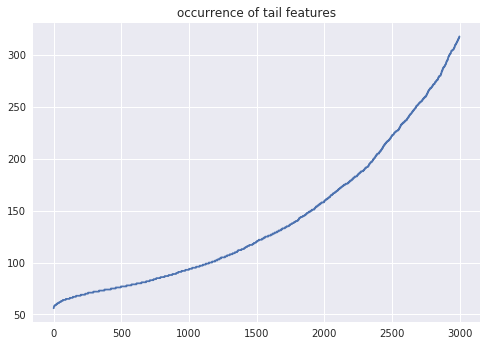

In [9]:
# usage of tail feature
plt.plot(sorted([np.count_nonzero(X_tr[:,i]) for i in range(X_tr.shape[1])], reverse=False)[:3000])
plt.title('occurrence of tail features')

## Binary mapping + kNN
data set $(x,y)^d$, where $y_i=\{1, 0\}^L$

we want to map y into lower space by $$z = [M\cdot y]$$ where M is a multivariant i,i,d Gaussian matrix, and $[]$ is tkaing the sign.

Then we train binary classifiers on each bit of $z \in \{0, 1\}^{\hat L}$

For each test point, we predict its $\hat z$ and then use kNN to find the nearest k neighbors from $z=[My]$ which is all our lower degree space's mapping.

## Step 0: data preposseing
normalize features and select prominent features

In [10]:
# normalize features
scaler = StandardScaler().fit(X_tr)
X_tr = scaler.transform(X_tr)
X_te = scaler.transform(X_te)
X_tr.shape

(15539, 5000)

In [27]:
# select prominent features


In [29]:
X_trs.shape

(15539, 2535)

### Step 1: map to $\hat L$ space and construct KD-tree

The data in "Eurlex" contains $L = 5000$ labels, we are trying to map it into $\hat L = 200$ space.

In [ ]:
np.random.seed(0)
L_hat = 200
M = normal(size=(L_hat, Y_tr.shape[1]))

In [ ]:
Z_tr = M.dot(Y_tr.T).T # z = n*\hat L
Z_tr = np.apply_along_axis(lambda x: [0 if elem < 0 else 1 for elem in x], 0, Z_tr)

In [ ]:
Z_tr.shape

In [ ]:
Y_tr.shape

In [ ]:
kd_tree = KDTree(Z_tr) #kNN search
#dist, ind = kd_tree.query(Z_tr[0].reshape(1,-1), k=3) #usage

In [ ]:
for bit in range(Z_tr.shape[1]):
    print "Trianning model for the {}th bit\n... ... ... ".format(bit)
    #clf = LogisticRegression(solver='sag')
    clf = LinearSVC(dual=False)
    clf.fit(y=Z_tr[:, bit], X=X_tr)
    joblib.dump(clf, os.path.join(model_path , 'label{}.pkl'.format(bit)))
    print "{}th bit's model successfully stored in {}/label{}.pkl\n".format(bit, model_path, bit)